In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import kstest, shapiro

import sys
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('churn.csv')

In [3]:
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.shape

(10000, 14)

# 1. Data Pre Processing

In [5]:
# Missing Values handling

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


no values is missing or null

In [7]:
# Duplicated data handling

In [8]:
df.duplicated().sum()

0

no data is **duplicated**

In [9]:
# Label and One hot encoding

In [10]:
mapping_gender = {
    'Male' : 0,
    'Female' : 1
}

df['Gender'] = df['Gender'].map(mapping_gender)

In [11]:
for cat in ['Geography']:
  onehots = pd.get_dummies(df[cat], prefix=cat)
  df = df.join(onehots)

In [12]:
# Split data

In [13]:
X = df[['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Geography_France', 'Geography_Germany', 'Geography_Spain']]
y = df[['Exited']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
# outlier handling

In [15]:
df_train = X_train.join(y_train)
df_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Exited
9069,619,1,32,4,175406.13,2,1,1,172792.43,0,0,1,1
2603,643,1,34,7,160426.07,1,0,1,188533.11,0,1,0,0
7738,561,0,33,6,0.00,2,0,0,173680.39,1,0,0,0
1579,618,0,41,8,37702.79,1,1,1,195775.48,0,1,0,0
5058,714,0,37,9,148466.93,2,0,1,151280.96,1,0,0,0


In [16]:
numcols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

In [17]:
from scipy import stats

print(f'{len(df_train)} rows before outlier filtering')

filtered_entries = np.array([True] * len(df_train))

for col in numcols:
    zscore = abs(stats.zscore(df_train[col]))
    filtered_entries = (zscore < 3) & filtered_entries
    
df_train = df_train[filtered_entries]

print(f'{len(df_train)} rows after outlier filtering')

7000 rows before outlier filtering
6903 rows after outlier filtering


141 row has been filtered from outlier

In [18]:
# Feature Transformation

<AxesSubplot:xlabel='Age', ylabel='Density'>

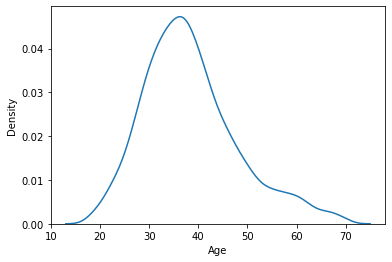

In [19]:
sns.kdeplot(x='Age', data=df_train)

<AxesSubplot:xlabel='log_Age', ylabel='Density'>

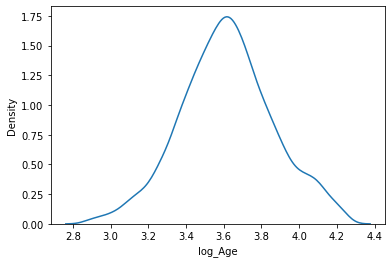

In [20]:
df_train['log_Age'] = np.log(df_train['Age'])

sns.kdeplot(x='log_Age', data=df_train)

In [21]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

df_train['CreditScore_std'] = MinMaxScaler().fit_transform(df_train['CreditScore'].values.reshape(len(df_train), 1))
df_train['Balance_std'] = MinMaxScaler().fit_transform(df_train['Balance'].values.reshape(len(df_train), 1))
df_train['EstimatedSalary_std'] = MinMaxScaler().fit_transform(df_train['EstimatedSalary'].values.reshape(len(df_train), 1))
df_train['log_Age_std'] = MinMaxScaler().fit_transform(df_train['log_Age'].values.reshape(len(df_train), 1))

In [22]:
df_train.describe()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Exited,log_Age,CreditScore_std,Balance_std,EstimatedSalary_std,log_Age_std
count,6903.000000,6903.000000,6903.000000,6903.000000,6903.000000,6903.000000,6903.000000,6903.000000,6903.000000,6903.000000,6903.000000,6903.000000,6903.000000,6903.000000,6903.000000,6903.000000,6903.000000,6903.000000
mean,652.187600,0.452122,38.412285,4.987687,76519.063552,1.525279,0.705925,0.509344,100894.829394,0.500652,0.248877,0.250471,0.209184,3.617439,0.592139,0.304981,0.504325,0.535347
std,96.138893,0.497738,9.705013,2.883620,62524.711702,0.581435,0.455659,0.499949,57640.488043,0.500036,0.432394,0.433316,0.406756,0.248623,0.198225,0.249204,0.288374,0.183064
min,365.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,90.070000,0.000000,0.000000,0.000000,0.000000,2.890372,0.000000,0.000000,0.000000,0.000000
25%,585.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,51939.430000,0.000000,0.000000,0.000000,0.000000,3.465736,0.453608,0.000000,0.259402,0.423646
50%,653.000000,0.000000,37.000000,5.000000,96654.720000,1.000000,1.000000,1.000000,100919.190000,1.000000,0.000000,0.000000,0.000000,3.610918,0.593814,0.385235,0.504447,0.530545
75%,720.000000,1.000000,43.000000,7.000000,127878.415000,2.000000,1.000000,1.000000,150411.940000,1.000000,0.000000,1.000000,0.000000,3.761200,0.731959,0.509683,0.752058,0.641200
max,850.000000,1.000000,70.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199970.740000,1.000000,1.000000,1.000000,1.000000,4.248495,1.000000,1.000000,1.000000,1.000000


In [23]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6903 entries, 9069 to 7270
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CreditScore          6903 non-null   int64  
 1   Gender               6903 non-null   int64  
 2   Age                  6903 non-null   int64  
 3   Tenure               6903 non-null   int64  
 4   Balance              6903 non-null   float64
 5   NumOfProducts        6903 non-null   int64  
 6   HasCrCard            6903 non-null   int64  
 7   IsActiveMember       6903 non-null   int64  
 8   EstimatedSalary      6903 non-null   float64
 9   Geography_France     6903 non-null   uint8  
 10  Geography_Germany    6903 non-null   uint8  
 11  Geography_Spain      6903 non-null   uint8  
 12  Exited               6903 non-null   int64  
 13  log_Age              6903 non-null   float64
 14  CreditScore_std      6903 non-null   float64
 15  Balance_std          6903 non-null 

In [24]:
df_train = df_train.drop(columns=['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'log_Age'])

In [25]:
df_train.to_csv('cm_train_final_non_classimbhandling.csv', index = False)

In [26]:
# Class Imbalance Handling

In [27]:
Xt = df_train[['Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 
               'Geography_France', 'Geography_Germany', 'Geography_Spain', 
               'CreditScore_std', 'Balance_std', 'EstimatedSalary_std', 'log_Age_std']]
yt = df_train[['Exited']]

from imblearn import under_sampling, over_sampling
Xt_under, yt_under = under_sampling.RandomUnderSampler(0.5).fit_resample(Xt, yt)
Xt_over, yt_over = over_sampling.RandomOverSampler(0.5).fit_resample(Xt, yt)
Xt_over_SMOTE, yt_over_SMOTE = over_sampling.SMOTE(0.5).fit_resample(Xt, yt)

In [28]:
print(yt.value_counts())
print(yt_under.value_counts())
print(yt_over.value_counts())
print(yt_over_SMOTE.value_counts())

Exited
0         5459
1         1444
dtype: int64
Exited
0         2888
1         1444
dtype: int64
Exited
0         5459
1         2729
dtype: int64
Exited
0         5459
1         2729
dtype: int64


In [29]:
print(Xt.shape)
print(Xt_under.shape)
print(Xt_over.shape)
print(Xt_over_SMOTE.shape)

(6903, 12)
(4332, 12)
(8188, 12)
(8188, 12)


In [30]:
XtYt_smote = Xt_over_SMOTE.join(yt_over_SMOTE)
XtYt_smote.head()

,Gender,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,CreditScore_std,Balance_std,EstimatedSalary_std,log_Age_std,Exited
0,1,4,2,1,1,0,0,1,0.523711,0.699113,0.864027,0.423646,1
1,1,7,1,0,1,0,1,0,0.573196,0.639407,0.942778,0.468285,0
2,0,6,2,0,0,1,0,0,0.404124,0.000000,0.868470,0.446304,0
3,0,8,1,1,1,0,1,0,0.521649,0.150271,0.979011,0.606131,0
4,0,9,2,0,1,1,0,0,0.719588,0.591742,0.756406,0.530545,0


In [31]:
XtYt_smote.to_csv('cm_train_final.csv', index = False)

## Test Data Preprocessing (Log Transformation and Standardization)

In [32]:
df_test = X_test.join(y_test)
df_test.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Exited
6252,596,0,32,3,96709.07,2,0,0,41788.37,0,1,0,0
4684,623,0,43,1,0.00,2,1,1,146379.30,1,0,0,0
1731,601,1,44,4,0.00,2,1,0,58561.31,0,0,1,0
4742,506,0,59,8,119152.10,2,1,1,170679.74,0,1,0,0
4521,560,1,27,7,124995.98,1,1,1,114669.79,0,0,1,0


<AxesSubplot:xlabel='Age', ylabel='Density'>

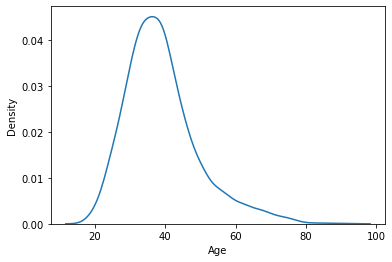

In [33]:
sns.kdeplot(x = 'Age', data = df_test)

<AxesSubplot:xlabel='log_Age', ylabel='Density'>

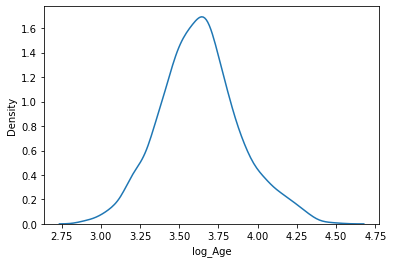

In [34]:
df_test['log_Age'] = np.log(df_test['Age'])

sns.kdeplot(x = 'log_Age', data = df_test)

In [35]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

df_test['CreditScore_std'] = MinMaxScaler().fit_transform(df_test['CreditScore'].values.reshape(len(df_test), 1))
df_test['Balance_std'] = MinMaxScaler().fit_transform(df_test['Balance'].values.reshape(len(df_test), 1))
df_test['EstimatedSalary_std'] = MinMaxScaler().fit_transform(df_test['EstimatedSalary'].values.reshape(len(df_test), 1))
df_test['log_Age_std'] = MinMaxScaler().fit_transform(df_test['log_Age'].values.reshape(len(df_test), 1))

In [36]:
df_test = df_test.drop(columns=['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'log_Age'])

In [37]:
Xts = df_test[['Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 
               'Geography_France', 'Geography_Germany', 'Geography_Spain', 
               'CreditScore_std', 'Balance_std', 'EstimatedSalary_std', 'log_Age_std']]
yts = df_test[['Exited']]

In [38]:
XtsYts = Xts.join(yts)
XtsYts.head()

,Gender,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,CreditScore_std,Balance_std,EstimatedSalary_std,log_Age_std,Exited
6252,0,3,2,0,0,0,1,0,0.492,0.447500,0.208904,0.352678,0
4684,0,1,2,1,1,1,0,0,0.546,0.000000,0.731908,0.533787,0
1731,1,4,2,1,0,0,0,1,0.502,0.000000,0.292777,0.547878,0
4742,0,8,2,1,1,0,1,0,0.312,0.551350,0.853422,0.727690,0
4521,1,7,1,1,1,0,0,1,0.420,0.578391,0.573346,0.248536,0


In [39]:
XtsYts.to_csv('cm_test_final.csv', index = False)

.

# ML PROCESS

In [41]:
mcln_train = pd.read_csv('cm_train_final.csv')
mcln_test = pd.read_csv('cm_test_final.csv')

# Training
X_train = mcln_train[['Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
                      'Geography_France', 'Geography_Germany', 'Geography_Spain',
                      'CreditScore_std', 'Balance_std', 'EstimatedSalary_std', 'log_Age_std']]
y_train = mcln_train[['Exited']]

# Testing
X_test = mcln_test[['Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
                    'Geography_France', 'Geography_Germany', 'Geography_Spain',
                    'CreditScore_std', 'Balance_std', 'EstimatedSalary_std', 'log_Age_std']]
y_test = mcln_test[['Exited']]

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    #print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_pred_train))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    #print("Precision (Train Set): %.2f" % precision_score(y_train, y_pred_train))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    #print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    #print("F1-Score (Train Set): %.2f" % f1_score(y_train, y_pred_train))
    
    print("AUC (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("AUC (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
#     print("AUC (test-label): %.2f" % roc_auc_score(y_test, y_pred))
#     print("AUC (train-label): %.2f" % roc_auc_score(y_train, y_pred_train))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

### 1. LogisticRegression

In [43]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

eval_classification(lr)

Accuracy (Test Set): 0.82
Precision (Test Set): 0.57
Recall (Test Set): 0.27
F1-Score (Test Set): 0.37
AUC (test-proba): 0.78
AUC (train-proba): 0.80


### K-Nearest Neighbor

In [44]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
eval_classification(knn)

Accuracy (Test Set): 0.77
Precision (Test Set): 0.42
Recall (Test Set): 0.42
F1-Score (Test Set): 0.42
AUC (test-proba): 0.72
AUC (train-proba): 0.94


param value: 30; train: 0.8339727759034652; test: 0.7752235382835889
param value: 31; train: 0.8339727759034652; test: 0.7752235382835889
param value: 32; train: 0.8339727759034652; test: 0.7752235382835889
param value: 33; train: 0.8339727759034652; test: 0.7752235382835889
param value: 34; train: 0.8339727759034652; test: 0.7752235382835889
param value: 35; train: 0.8339727759034652; test: 0.7752235382835889
param value: 36; train: 0.8339727759034652; test: 0.7752235382835889
param value: 37; train: 0.8339727759034652; test: 0.7752235382835889
param value: 38; train: 0.8339727759034652; test: 0.7752235382835889
param value: 39; train: 0.8339727759034652; test: 0.7752235382835889
param value: 40; train: 0.8339727759034652; test: 0.7752235382835889
param value: 41; train: 0.8339727759034652; test: 0.7752235382835889
param value: 42; train: 0.8339727759034652; test: 0.7752235382835889
param value: 43; train: 0.8339727759034652; test: 0.7752235382835889
param value: 44; train: 0.83397277

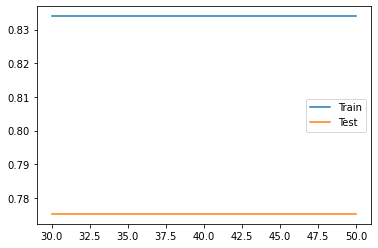

In [45]:
param_values = [int(x) for x in np.linspace(30, 50, 21)]

train_scores = []
test_scores = []

for cknn in param_values:
  model = KNeighborsClassifier(n_neighbors = 36, p = 4, leaf_size = cknn)
  model.fit(X_train, y_train)
	
  y_pred_train_proba = model.predict_proba(X_train)
  train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
  train_scores.append(train_auc)
  
  y_pred_proba = model.predict_proba(X_test)
  test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
  test_scores.append(test_auc)
  
  print('param value: ' + str(cknn) + '; train: ' + str(train_auc) + '; test: ' + str(test_auc))

plt.plot(param_values, train_scores, label = 'Train')
plt.plot(param_values, test_scores, label = 'Test')
plt.legend()
plt.show()

In [46]:
from sklearn.neighbors import KNeighborsClassifier
knn_tuned = KNeighborsClassifier(n_neighbors = 59, p = 1, leaf_size = 30,  weights = 'uniform')
knn_tuned.fit(X_train,y_train)
eval_classification(knn_tuned)

Accuracy (Test Set): 0.82
Precision (Test Set): 0.55
Recall (Test Set): 0.35
F1-Score (Test Set): 0.43
AUC (test-proba): 0.79
AUC (train-proba): 0.83


### Decision Tree

In [47]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=1)
dtc.fit(X_train,y_train)

eval_classification(dtc)

Accuracy (Test Set): 0.78
Precision (Test Set): 0.45
Recall (Test Set): 0.49
F1-Score (Test Set): 0.47
AUC (test-proba): 0.67
AUC (train-proba): 1.00


In [48]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform

criterion = ['gini', 'entropy']
max_depth = [int(x) for x in np.linspace(1, 100, 100)]
min_samples_split = [int(x) for x in np.linspace(2, 200, 100)]
min_samples_leaf = [int(x) for x in np.linspace(1, 100, 100)]
max_features = ['auto', 'sqrt']
random_state = [int(x) for x in np.linspace(1, 84, 100)]
hyperparameters = dict(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, 
                       min_samples_leaf=min_samples_leaf, max_features=max_features)

dtc.fit(X_train, y_train)
rs_dtc = RandomizedSearchCV(dtc, hyperparameters, scoring = 'roc_auc', cv = 5)
rs_dtc.fit(X_train, y_train)
eval_classification(rs_dtc)

Accuracy (Test Set): 0.83
Precision (Test Set): 0.63
Recall (Test Set): 0.32
F1-Score (Test Set): 0.42
AUC (test-proba): 0.80
AUC (train-proba): 0.86


In [49]:
show_best_hyperparameter(rs_dtc)

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 67, 'min_samples_split': 144, 'min_weight_fraction_leaf': 0.0, 'random_state': 1, 'splitter': 'best'}


In [50]:
from sklearn.model_selection import cross_validate

model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 79, min_samples_split = 180, min_samples_leaf = 47, max_features = 'sqrt', random_state = 1)
score = cross_validate(model, X, y, cv = 5, scoring = 'roc_auc', return_train_score = True)

print('roc_auc(train): ' + str(score['train_score'].mean()))
print('roc_auc(test): ' + str(score['test_score'].mean()))

roc_auc(train): 0.8037384061779921
roc_auc(test): 0.7717708853068321


In [51]:
from sklearn.tree import DecisionTreeClassifier
dtc_tuned = DecisionTreeClassifier(criterion = 'entropy', max_depth = 79, min_samples_split = 180, min_samples_leaf = 47, max_features = 'sqrt', random_state = 1)
dtc_tuned.fit(X_train,y_train)

eval_classification(dtc_tuned)

Accuracy (Test Set): 0.82
Precision (Test Set): 0.54
Recall (Test Set): 0.43
F1-Score (Test Set): 0.48
AUC (test-proba): 0.79
AUC (train-proba): 0.85


param value: 1; train: 0.5712416239086925; test: 0.5445428734237504
param value: 2; train: 0.7762718129772619; test: 0.6889731272112855
param value: 3; train: 0.8056974034293148; test: 0.7581232848362516
param value: 4; train: 0.8273896062932506; test: 0.8015300394629411
param value: 5; train: 0.7185515180923975; test: 0.6608589710151502
param value: 6; train: 0.8286101711207252; test: 0.7937012383198766
param value: 7; train: 0.8291037066278615; test: 0.7926331590764764
param value: 8; train: 0.8382994427764291; test: 0.8000958932459404
param value: 9; train: 0.8123886104960051; test: 0.7628236840016329
param value: 10; train: 0.8310417019212006; test: 0.7963951793976232
param value: 11; train: 0.8442954041423152; test: 0.799743646806677
param value: 12; train: 0.8369901724511399; test: 0.798973594983217


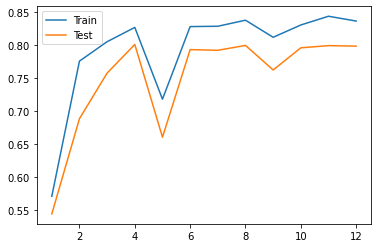

In [53]:
param_values = [int(x) for x in np.linspace(1, 12, 12)]

train_scores = []
test_scores = []

for cdtc in param_values:
  model = DecisionTreeClassifier(max_depth = 4, min_samples_split = 155, min_samples_leaf = 62, max_features = cdtc)
  model.fit(X_train, y_train)
	
  y_pred_train_proba = model.predict_proba(X_train)
  train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
  train_scores.append(train_auc)
  
  y_pred_proba = model.predict_proba(X_test)
  test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
  test_scores.append(test_auc)
  
  print('param value: ' + str(cdtc) + '; train: ' + str(train_auc) + '; test: ' + str(test_auc))

plt.plot(param_values, train_scores, label = 'Train')
plt.plot(param_values, test_scores, label = 'Test')
plt.legend()
plt.show()

.

### Random Forest Classifier

In [54]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)

eval_classification(rf)

Accuracy (Test Set): 0.86
Precision (Test Set): 0.74
Recall (Test Set): 0.40
F1-Score (Test Set): 0.52
AUC (test-proba): 0.84
AUC (train-proba): 1.00


In [55]:
# Tuning Hyperparameter Random Forest
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(1, 200, 50)]
criterion = ['gini', 'entropy']
max_depth = [int(x) for x in np.linspace(2, 100, 50)]
min_samples_split = [int(x) for x in np.linspace(2, 100, 50)]
min_samples_leaf = [int(x) for x in np.linspace(2, 150, 50)]
random_state = 1
hyperparameters = dict(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, 
                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

rf.fit(X_train, y_train)
rs_rf = RandomizedSearchCV(rf, hyperparameters, scoring = 'roc_auc', cv = 5)
rs_rf.fit(X_train, y_train)
eval_classification(rs_rf)

Accuracy (Test Set): 0.86
Precision (Test Set): 0.76
Recall (Test Set): 0.40
F1-Score (Test Set): 0.53
AUC (test-proba): 0.86
AUC (train-proba): 0.94


In [56]:
show_best_hyperparameter(rs_rf)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 40, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 8, 'min_samples_split': 36, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 45, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [57]:
from sklearn.model_selection import cross_validate

model = RandomForestClassifier(n_estimators = 74, max_depth = 70, min_samples_split = 78, min_samples_leaf = 2, random_state = 42)
score = cross_validate(model, X, y, cv = 5, scoring = 'roc_auc', return_train_score = True)

print('roc_auc(train): ' + str(score['train_score'].mean()))
print('roc_auc(test): ' + str(score['test_score'].mean()))

roc_auc(train): 0.9127702755580032
roc_auc(test): 0.8595490594270793


In [58]:
from sklearn.ensemble import RandomForestClassifier
rf_tuned = RandomForestClassifier(n_estimators = 74, max_depth = 70, min_samples_split = 78, min_samples_leaf = 2, random_state = 42)
rf_tuned.fit(X_train,y_train)

eval_classification(rf_tuned)

Accuracy (Test Set): 0.86
Precision (Test Set): 0.78
Recall (Test Set): 0.39
F1-Score (Test Set): 0.52
AUC (test-proba): 0.86
AUC (train-proba): 0.93


param value: 1; train: 0.921836326643245; test: 0.860048308083099
param value: 3; train: 0.9198698368483376; test: 0.8596095947110587
param value: 5; train: 0.9182251436153086; test: 0.8587059443890048
param value: 7; train: 0.9172067924179251; test: 0.8561828109407601
param value: 9; train: 0.916413846488541; test: 0.855168596344008
param value: 11; train: 0.9166548918480957; test: 0.8572466377120567
param value: 13; train: 0.9144037926617898; test: 0.8574911548580241
param value: 15; train: 0.9135733239376433; test: 0.854495288260909
param value: 17; train: 0.9131877587621263; test: 0.8555817948834256
param value: 19; train: 0.9121042293291186; test: 0.8553592488433276
param value: 21; train: 0.9114828545328509; test: 0.8539474281048717
param value: 23; train: 0.9111710595745854; test: 0.8529721945024041
param value: 25; train: 0.91144378786639; test: 0.8534626462850403
param value: 27; train: 0.9089121739049302; test: 0.8517354338655538
param value: 29; train: 0.9089581544316065; te

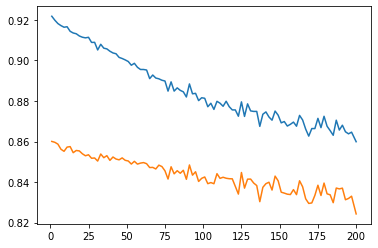

In [60]:
param_values = [int(x) for x in np.linspace(1, 200, 100)]

train_scores = []
test_scores = []

for crf in param_values:
  model = RandomForestClassifier(n_estimators = 118, max_depth = 28, min_samples_split = 98, min_samples_leaf = crf)
  model.fit(X_train, y_train)
	
  y_pred_train_proba = model.predict_proba(X_train)
  train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
  train_scores.append(train_auc)
  
  y_pred_proba = model.predict_proba(X_test)
  test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
  test_scores.append(test_auc)
  
  print('param value: ' + str(crf) + '; train: ' + str(train_auc) + '; test: ' + str(test_auc))

plt.plot(param_values, train_scores, label = 'Train')
plt.plot(param_values, test_scores, label = 'Test')
plt.show()

n_estimator 118 max_depth 28 min_samples_split 98 min_samples_leaf 164

Setelah dilakukan Hyperparameter Tuning, didapatkan hasil bahwa nilai yang paling tepat untuk parameter n_estimators adalah 118, max_depth = 27 dan min_sample_leaf = 135.

.

### AdaBoost

In [61]:
from sklearn.ensemble import AdaBoostClassifier
ab = AdaBoostClassifier(random_state=42)
ab.fit(X_train,y_train)

eval_classification(ab)

Accuracy (Test Set): 0.84
Precision (Test Set): 0.65
Recall (Test Set): 0.45
F1-Score (Test Set): 0.53
AUC (test-proba): 0.84
AUC (train-proba): 0.88


In [62]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

n_estimators = [int(x) for x in np.linspace(50, 200, 50)]
learning_rate = [float(x) for x in np.linspace(0.001, 0.1, 50)]
algorithm = ['SAMME', 'SAMME.R']
hyperparameters = dict(n_estimators = n_estimators, learning_rate = learning_rate,  algorithm = algorithm
                       )

ab = AdaBoostClassifier(random_state=42)
ab.fit(X_train, y_train)
rs_ab = RandomizedSearchCV(ab, hyperparameters, scoring = 'roc_auc', cv = 5)
rs_ab.fit(X_train, y_train)
eval_classification(rs_ab)

Accuracy (Test Set): 0.84
Precision (Test Set): 0.69
Recall (Test Set): 0.37
F1-Score (Test Set): 0.48
AUC (test-proba): 0.84
AUC (train-proba): 0.86


In [63]:
show_best_hyperparameter(rs_ab)

{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.09191836734693878, 'n_estimators': 71, 'random_state': 42}


In [64]:
from sklearn.model_selection import cross_validate

model = AdaBoostClassifier(n_estimators = 108, learning_rate =  0.08181632653061224, algorithm = 'SAMME.R')
score = cross_validate(model, X, y, cv = 5, scoring = 'roc_auc', return_train_score = True)

print('roc_auc(train): ' + str(score['train_score'].mean()))
print('roc_auc(test): ' + str(score['test_score'].mean()))

roc_auc(train): 0.8484399289382925
roc_auc(test): 0.8444039488715214


In [65]:
from sklearn.ensemble import AdaBoostClassifier
ab_tuned = AdaBoostClassifier(n_estimators = 108, learning_rate =  0.08181632653061224, algorithm = 'SAMME.R', random_state=42)
ab_tuned.fit(X_train,y_train)

eval_classification(ab_tuned)

Accuracy (Test Set): 0.85
Precision (Test Set): 0.69
Recall (Test Set): 0.38
F1-Score (Test Set): 0.49
AUC (test-proba): 0.84
AUC (train-proba): 0.86


param value: 0.001; train: 0.7318358628104867; test: 0.6631003781865191
param value: 0.0030204081632653063; train: 0.7418713309133927; test: 0.6771891726390274
param value: 0.0050408163265306125; train: 0.762074872273145; test: 0.7046296663793885
param value: 0.007061224489795919; train: 0.8016768259018174; test: 0.7651756554477003
param value: 0.009081632653061226; train: 0.8083879354884485; test: 0.7815487361652906
param value: 0.011102040816326531; train: 0.8240165151311845; test: 0.7975766578971242
param value: 0.013122448979591837; train: 0.8287766743271789; test: 0.8012933185158305
param value: 0.015142857142857145; train: 0.8357206064784481; test: 0.8110938492243491
param value: 0.01716326530612245; train: 0.8407913523852917; test: 0.8153243502222625
param value: 0.019183673469387756; train: 0.8434239221308704; test: 0.8170111641567631
param value: 0.02120408163265306; train: 0.8454287402188176; test: 0.8186157636305906
param value: 0.02322448979591837; train: 0.8471112918708912

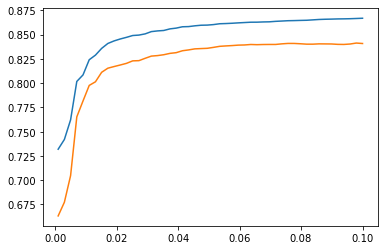

In [66]:
param_values_adaboost = [float(x) for x in np.linspace(0.001, 0.1, 50)]

train_scores = []
test_scores = []

for cab in param_values_adaboost:
  model = AdaBoostClassifier(n_estimators = 129, learning_rate = cab)
  model.fit(X_train, y_train)
	
  y_pred_train_proba = model.predict_proba(X_train)
  train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
  train_scores.append(train_auc)
  
  y_pred_proba = model.predict_proba(X_test)
  test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
  test_scores.append(test_auc)
  
  print('param value: ' + str(cab) + '; train: ' + str(train_auc) + '; test: ' + str(test_auc))

plt.plot(param_values_adaboost, train_scores, label = 'Train')
plt.plot(param_values_adaboost, test_scores, label = 'Test')
plt.show()

### XGBoost

In [67]:
from xgboost import XGBClassifier, XGBRegressor
xg = XGBClassifier(random_state=42)
xg.fit(X_train, y_train)

eval_classification(xg)

Accuracy (Test Set): 0.78
Precision (Test Set): 0.46
Recall (Test Set): 0.70
F1-Score (Test Set): 0.56
AUC (test-proba): 0.83
AUC (train-proba): 0.99


In [74]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

hyperparameters = {
                    'max_depth' : [int(x) for x in np.linspace(1, 15, 15)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 100, 100)],
                    'min_split_loss' : [float(x) for x in np.linspace(0, 1, 100)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],
                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, 100)],
                    'learning_rate' : [float(x) for x in np.linspace(0, 0.1, 100)],
                    }

xg = XGBClassifier(random_state=42)
xg.fit(X_train, y_train)
rs_xg = RandomizedSearchCV(xg, hyperparameters, scoring = 'roc_auc', cv = 5)
rs_xg.fit(X_train, y_train)
eval_classification(rs_xg)

OverflowError: Python int too large to convert to C long

In [75]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Reduce the number of values searched for each hyperparameter
hyperparameters = {
                    'max_depth' : [int(x) for x in np.linspace(1, 15, 3)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 100, 10)],
                    'min_split_loss' : [float(x) for x in np.linspace(0, 1, 10)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],
                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, 10)],
                    'learning_rate' : [float(x) for x in np.linspace(0, 0.1, 10)],
                    }

xg = XGBClassifier(random_state=42)
xg.fit(X_train, y_train)
rs_xg = RandomizedSearchCV(xg, hyperparameters, scoring = 'roc_auc', cv = 5)
rs_xg.fit(X_train, y_train)
eval_classification(rs_xg)


Accuracy (Test Set): 0.84
Precision (Test Set): 0.60
Recall (Test Set): 0.60
F1-Score (Test Set): 0.60
AUC (test-proba): 0.85
AUC (train-proba): 0.96


In [76]:
show_best_hyperparameter(rs_xg)

{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.7777777777777777, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': 0, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.03333333333333333, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 8, 'max_leaves': 0, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'approx', 'validate_parameters': 1, 'verbosity': None, 'min_split_loss': 0.2222222222222222}


In [71]:
from sklearn.model_selection import cross_validate

model = XGBClassifier(max_depth = 4, min_child_weight = 9, min_split_loss = 0.42424242424242425, 
                      tree_method = 'approx', colsample_bytree = 0.5454545454545455, learning_rate = 0.03333333333333333
                      )
score = cross_validate(model, X, y, cv = 5, scoring = 'roc_auc', return_train_score = True)

print('roc_auc(train): ' + str(score['train_score'].mean()))
print('roc_auc(test): ' + str(score['test_score'].mean()))

roc_auc(train): 0.8778940157324483
roc_auc(test): 0.8645190138500644


In [72]:
from xgboost import XGBClassifier, XGBRegressor
xg_tuned = XGBClassifier(max_depth = 4, min_child_weight = 9, min_split_loss = 0.42424242424242425, 
                   tree_method = 'approx', colsample_bytree = 0.5454545454545455, learning_rate = 0.03333333333333333,
                   random_state=42)
xg_tuned.fit(X_train, y_train)

eval_classification(xg_tuned)

Accuracy (Test Set): 0.86
Precision (Test Set): 0.76
Recall (Test Set): 0.45
F1-Score (Test Set): 0.56
AUC (test-proba): 0.86
AUC (train-proba): 0.90


**Feature Importance**

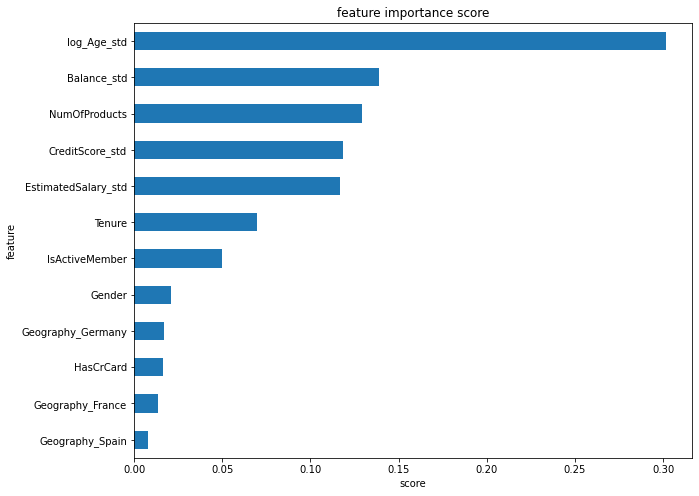

In [77]:
show_feature_importance(dtc)

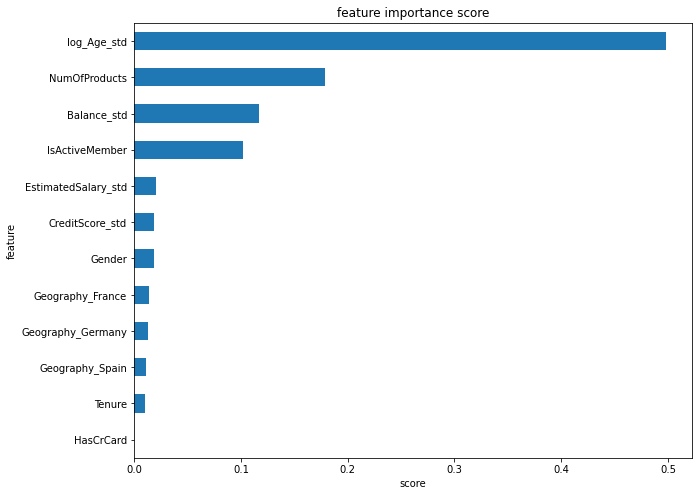

In [78]:
show_feature_importance(dtc_tuned)

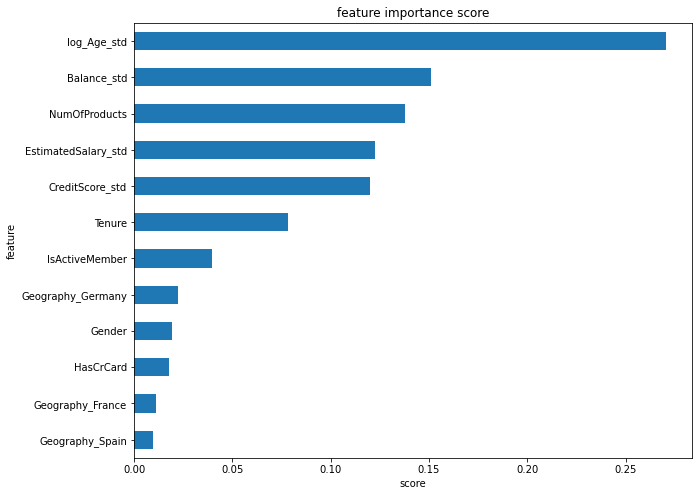

In [79]:
show_feature_importance(rf)

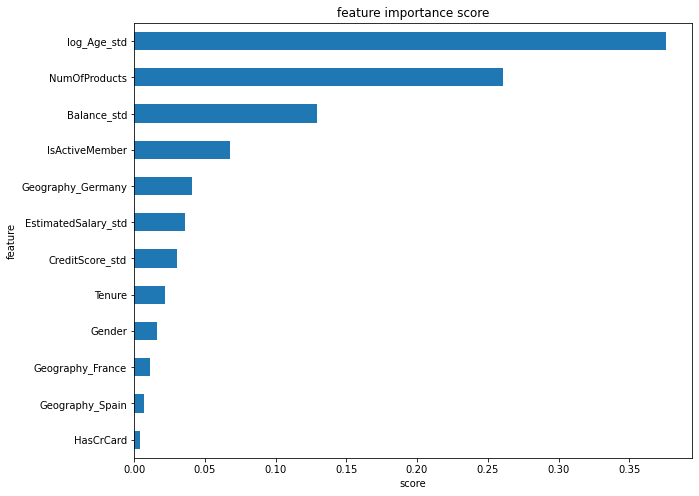

In [80]:
show_feature_importance(rf_tuned)

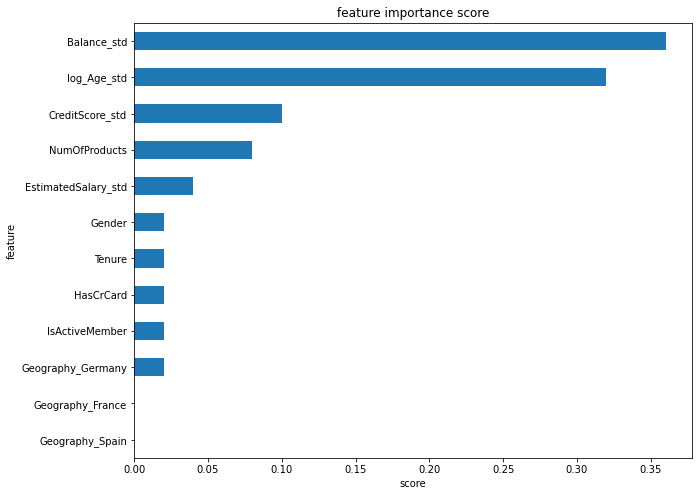

In [81]:
show_feature_importance(ab)

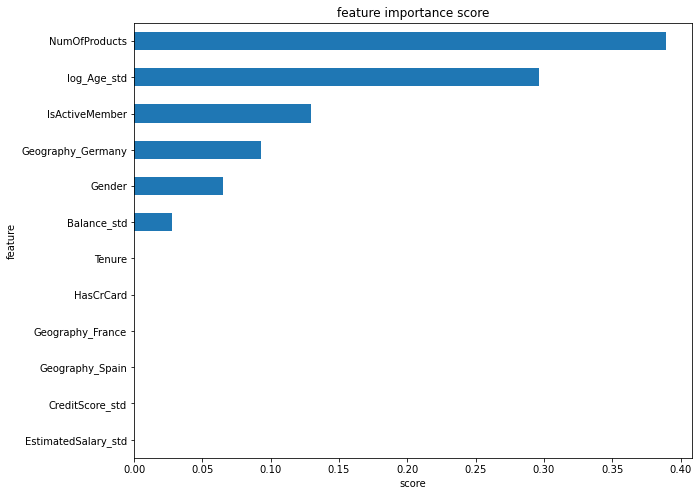

In [82]:
show_feature_importance(ab_tuned)

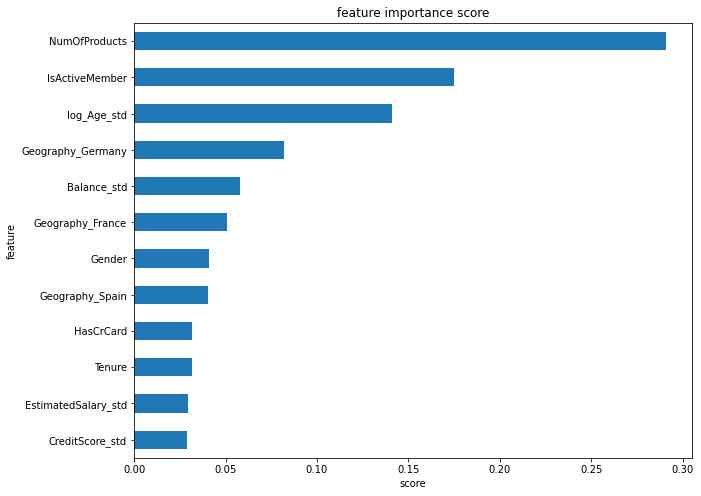

In [83]:
show_feature_importance(xg)

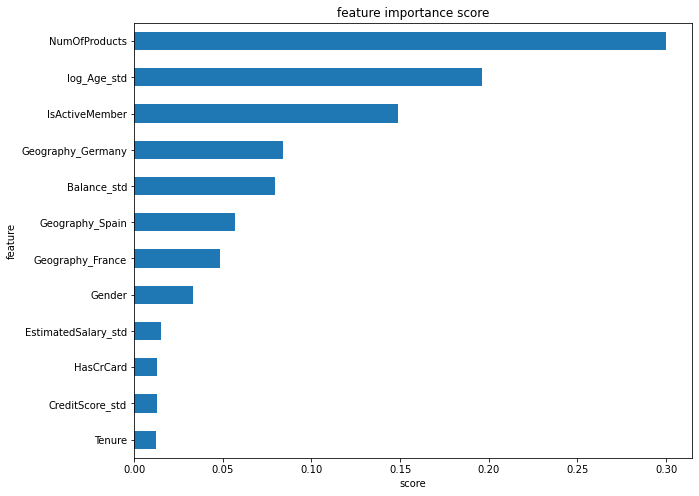

In [84]:
show_feature_importance(xg_tuned)

Berdasarkan feature importance yang telah dimunculkan pada model XGBoost, Empat fitur teratas adalah NumOfProducts, Age, IsActiveMember, dan Geography.